## Fine-tuning de Hiper-parâmetros

Todos os classificadores que utilizamos até aqui possuem uma série de hiper-parâmetros que precisam ser ajustados para que possamos obter o máximo desempenho possível de cada um.

**Parêntese: o que são hiper-parâmetros afinal? Por que não os chamamos simplesmente de "parâmetros"?**

Tecnicamente, os parâmetros do modelo são aqueles que são aprendidos *durante* o treinamento, e que determinam como uma determinada observação deve ser classificada. As configurações que são ajustados pelo usuário e que determinam como o treinamento deve ocorrer, são chamados de hiper-parâmetros, para diferenciar.

### Estratégias para fine-tuning:

1. Tentativa e erro, ajustando hiper-parâmetros manualmente (!)
2. Busca sistemática

É claro que vamos tratar da segunda opção aqui.

O scikit-learn fornece dois mecanismos para busca sistemática:

- Grid search
- Random search

Externamente, os dois funcionam da mesma forma: o usuário define um conjunto ou faixa de valores para cada hiper-parâmetro, o "searcher" monta todas as combinações possíveis e treina um classificador para cada combinação.

Internamente, o grid search é exaustivo, ou seja, todas as opções são exploradas, enquanto que o random search explora regiões do grid aleatoriamente. Na prática, o random search produz resultados quase tão bons quanto o grid search, mas com muito menos treinamentos, e portanto, em menos tempo.



In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [15, 15]

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np

#define função para criar plots com fronteiras de decisão
def plot_decision_boundary(clf, X, y):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(4, 3))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.tab20)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.tab20b, s=5)
    plt.axis('off')


#### Criação de dados de exemplo utilizando make_moons

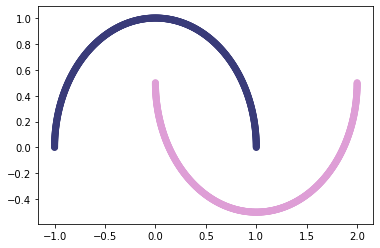

In [2]:
X, y = make_moons(n_samples=1000, random_state=42)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.tab20b)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Exemplo de Grid Search com Gradient Boosting

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats

clf = GradientBoostingClassifier()

param_grid = {  'learning_rate': [0.01, 0.1, 0.5],
                'n_estimators': [5, 20, 100],
                'subsample': [0.6, 1.0], #stats.uniform(0.6, 0.4),
                'criterion': ['friedman_mse', 'mse', 'mae'],
                'max_depth': [1, 3, 5, 7],
                'max_features': [1, 2]}

grid = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=4, iid=False)
%time grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_estimator_.score(X_test, y_test))

CPU times: user 2.21 s, sys: 57.4 ms, total: 2.27 s
Wall time: 56.8 s
{'criterion': 'mse', 'learning_rate': 0.1, 'max_depth': 5, 'max_features': 1, 'n_estimators': 20, 'subsample': 1.0}
1.0


### Exemplo de Random Search com Gradient Boosting

In [4]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

n_iter = 20

clf = GradientBoostingClassifier()

param_dist = {  'learning_rate': [0.01, 0.1, 0.5],
                'n_estimators': [5, 20, 100],
                'subsample': stats.uniform(0.6, 0.4),
                'criterion': ['friedman_mse', 'mse', 'mae'],
                'max_depth': [1, 3, 5, 7],
                'max_features': [1, 2]}

rand = RandomizedSearchCV(clf, param_distributions=param_dist, cv=5, n_jobs=4, n_iter=n_iter)
%time rand.fit(X_train, y_train)

print(rand.best_params_)
print(rand.best_estimator_.score(X_test, y_test))

CPU times: user 256 ms, sys: 20.3 ms, total: 276 ms
Wall time: 3.58 s
{'criterion': 'mae', 'learning_rate': 0.5, 'max_depth': 7, 'max_features': 2, 'n_estimators': 20, 'subsample': 0.654092116796517}
1.0


In [5]:
rand.cv_results_

{'mean_fit_time': array([0.03043919, 0.47976837, 0.07396002, 0.00602665, 0.00858793,
        1.0233799 , 0.04839878, 0.07633839, 0.12678823, 0.00575099,
        0.00585241, 0.00467987, 0.64135375, 0.10993562, 0.00949168,
        0.02272267, 0.72133389, 0.00699325, 0.02368207, 0.14922013]),
 'std_fit_time': array([4.21491713e-03, 1.88955754e-02, 2.21233677e-03, 1.41398066e-04,
        8.13871182e-04, 2.44799395e-01, 4.08659772e-03, 8.53613051e-03,
        7.85671910e-03, 1.99106186e-04, 1.30654895e-04, 1.10570137e-04,
        2.21534999e-01, 5.37753417e-02, 2.40303112e-03, 3.51652379e-03,
        2.06790105e-01, 1.22259823e-03, 1.84373538e-04, 2.52406357e-02]),
 'mean_score_time': array([0.00116534, 0.0014627 , 0.00081758, 0.00066733, 0.00068288,
        0.00169573, 0.00074501, 0.00081134, 0.00095415, 0.00066175,
        0.00064702, 0.00063338, 0.0016418 , 0.00197825, 0.00080214,
        0.00084133, 0.00134449, 0.00053296, 0.00064735, 0.00067148]),
 'std_score_time': array([7.18562942e-

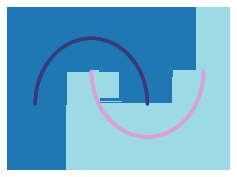

In [6]:
plot_decision_boundary(grid.best_estimator_, X, y)

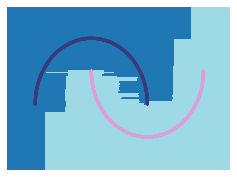

In [7]:
plot_decision_boundary(rand.best_estimator_, X, y)